In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import einops

import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
def SO3_gens():
    Lz = torch.tensor([[0,1,0],[-1,0,0],[0,0,0]],dtype = torch.float32)
    Ly = torch.tensor([[0,0,-1],[0,0,0],[1,0,0]],dtype = torch.float32)
    Lx = torch.tensor([[0,0,0],[0,0,1],[0,-1,0]],dtype = torch.float32)
    gens = [Lx, Ly, Lz]
    return gens

In [4]:
def Lorentz_gens():

    #p^a= p[a] -> Jz[a,b]p[b] (p_a = p[a] -> Jz[a,b]p[b])
    Lz = torch.tensor([[0,0,0,0],[0,0,1,0],[0,-1,0,0],[0,0,0,0]],dtype = torch.float32)
    Ly = torch.tensor([[0,0,0,0],[0,0,0,-1],[0,0,0,0],[0,1,0,0]],dtype = torch.float32)
    Lx = torch.tensor([[0,0,0,0],[0,0,0,0],[0,0,0,1],[0,0,-1,0]],dtype = torch.float32)


    #p^a = p[a] -> Kz[a,b]p[b] (p_a = p[a] -> -Kz[a,b]p[b])
    Kz = torch.tensor([[0,0,0,1],[0,0,0,0],[0,0,0,0],[1,0,0,0]],dtype = torch.float32)
    Ky = torch.tensor([[0,0,1,0],[0,0,0,0],[1,0,0,0],[0,0,0,0]],dtype = torch.float32)
    Kx = torch.tensor([[0,1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]],dtype = torch.float32)

    gens = [Kx, Ky, Kz, Lx, Ly, Lz]
    return gens

In [5]:
gens_SO3 = einops.rearrange(SO3_gens(),'n h w -> n h w')

In [6]:
gens_Lorentz = einops.rearrange(Lorentz_gens(),'n h w -> n h w')

In [8]:
devicef = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {devicef} device")

Using mps device


In [100]:
class SymmLoss(nn.Module):

    def __init__(self, gens_list,model,device = devicef):
        super(SymmLoss, self).__init__()
        
        self.model = model.to(device)
        self.device = device
        # Initialize generators (in future add different reps for inputs?)
        self.generators = einops.rearrange(gens_list, 'n w h -> n w h')
        self.generators = self.generators.to(device)
        

    
    def forward(self, input, model_rep='scalar',norm = "none"):
        
        input = input.clone().detach().requires_grad_(True)
        input = input.to(self.device)
        # Compute model output, shape [B]
        output = self.model(input)

        # Compute gradients with respect to input, shape [B, d*N], B is the batch size, d is the inpur irrep dimension, N is the number of particles
        grads, = torch.autograd.grad(outputs=output, inputs=input, grad_outputs=torch.ones_like(output, device=self.device), create_graph=True)
        
        # Reshape grads to [B, N, d] 
        grads = einops.rearrange(grads, '... (N d) -> ... N d',d = self.generators.shape[-1])

        # Contract grads with generators, shape [n (generators), B, N, d]
        gen_grads = torch.einsum('n h d, ... N h->  n ... N d ',self.generators, grads)
        # Reshape to [n, B, (d N)]
        gen_grads = einops.rearrange(gen_grads, 'n ... N d -> n ... (N d)')

        # Dot with input [n ,B]
        differential_trans = torch.einsum('n ... N, ... N -> n ...', gen_grads, input)

        
        # # Reshape grads to [B, N, d] 
        # grads = einops.rearrange(grads, '(N d) -> N d',d = self.generators.shape[-1])

        # # Contract grads with generators, shape [n (generators), B, N, d]
        # gen_grads = torch.einsum('n h d,  N h->  n N d ',self.generators, grads)
        # # Reshape to [n, B, (d N)]
        # gen_grads = einops.rearrange(gen_grads, 'n N d -> n (N d)')

        # # Dot with input [n ,B]
        # differential_trans = torch.einsum('n N, N -> n', gen_grads, input)

        scalar_loss = (differential_trans ** 2).mean()
     
            
        return scalar_loss

In [10]:
class inv_model(nn.Module):

    def __init__(self,dinput = 4, doutput = 1,init = "rand"):
        super(inv_model,self).__init__()

        bi_tensor = torch.randn(dinput,dinput)

        if init=="eta":
            diag = torch.ones(dinput)*(-1.00)
            diag[0]=1.00
            bi_tensor = torch.diag(diag)

        elif init=="delta":
            bi_tensor = torch.diag(torch.ones(dinput)*1.00)
        
        
        bi_tensor = (bi_tensor+torch.transpose(bi_tensor,0,1))*0.5
        self.bi_tensor = torch.nn.Parameter(bi_tensor)
        self.bi_tensor.requires_grad_()

    def forward(self,x, sig = "euc", d = 3 ):
        #y = x @ (self.bi_tensor @ x.T)
        y = torch.einsum("...i,ij,...j-> ...",x,self.bi_tensor,x)
        # x = torch.dot(x,y)
        return y


In [126]:
class genNet(nn.Module):
    def __init__(self, input_size=4, output_size=1, hidden_size=10, n_hidden_layers=3, init="rand", equiv="False", rand = "True", freeze = "False",activation = "ReLU", skip = "False"):
        super().__init__()
        self.equiv=equiv
        self.skip = skip
        if rand=="False":
            np.random.seed(98235)
            torch.manual_seed(98235)

        if activation =="sigmoid":
            #input layer
            module_list = [nn.Linear(input_size, hidden_size), nn.Sigmoid()]
            # hidden layers
            for _ in range(n_hidden_layers):
                module_list.extend([nn.Linear(hidden_size, hidden_size), nn.Sigmoid()])

        else:
            #input layer
            module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
            # hidden layers
            for _ in range(n_hidden_layers):
                module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        # output layer
        module_list.append(nn.Linear(hidden_size, output_size))

        self.sequential = nn.Sequential(*module_list)

        dinput = input_size
        if self.equiv=="True":
            bi_tensor = torch.randn(input_size,input_size)

            if init=="eta":
                diag = torch.ones(dinput)*(-1.00)
                diag[0]=1.00
                bi_tensor = torch.diag(diag)

            elif init=="delta":
                bi_tensor = torch.diag(torch.ones(dinput)*1.00)
        
            bi_tensor = (bi_tensor+torch.transpose(bi_tensor,0,1))*0.5
            self.bi_tensor = bi_tensor.to(devicef)
            
            if (freeze =="False" or freeze == False):
                self.bi_tensor = torch.nn.Parameter(bi_tensor)
                self.bi_tensor.requires_grad_()

            self.equiv_layer = nn.Linear(1, input_size)
            self.skip_layer = nn.Linear(input_size, input_size)

    def forward(self,x):

        if self.equiv=="True":
            y = torch.einsum("...i,ij,...j-> ...",x,self.bi_tensor,x).unsqueeze(1)
            y = self.equiv_layer(y)
            if self.skip =="True":
                y = self.equiv_layer(y) + self.skip_layer(x)
            
        else:
            y = x

        return self.sequential(y)
        
        


In [127]:
class symm_net_train():

    def __init__(self,gens_list=gens_Lorentz,input_size = 4,init = "rand",equiv="False",rand="False",freeze = "False", activation = "ReLU", skip="False"):
        self.train_loss_vec = []
        self.symm_loss_vec = []
        self.tot_loss_vec = []
        self.running_loss = 0.0
        self.symm_loss = 0.0
        self.train_loss_lam = {}
        self.symm_loss_lam = {}
        self.tot_loss_lam = {}
        self.models = {}

        self.init = init
        self.equiv = equiv
        self.rand=rand
        self.freeze = freeze, 
        self.activation = activation
        self.skip=skip
        self.input_size = input_size
        self.gens_list=gens_list

    def Lorentz_myfun(input):
        m2 = torch.einsum("... i, ij, ...j -> ...",input, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])), input)
        out = m2**2+15*m2
        return out.unsqueeze(1)

    def prepare_dataset(self, N = 1000, dinput = 4, norm = 1, true_func = Lorentz_myfun, batch_size="all", shuffle=False, seed = 98235):

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        train_data = (torch.rand(N,dinput)-0.5)*norm
        #train_m2 = torch.einsum("... i, ij, ...j -> ...",train_data, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])), train_data)
        train_labels = true_func(train_data).squeeze()
        
        if batch_size=="all":
            batch_size = N

        # train_labels = torch.tensor(train_labels, dtype=torch.float32)
        # train_data = torch.tensor(train_data, dtype=torch.float32)
        train_dataset = TensorDataset(train_data,train_labels)
        self.train_dataset = train_dataset
        self.train_data = train_data
        self.train_labels = train_labels
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    def set_model(self,gens_list=gens_Lorentz,input_size = 4,init = "rand",equiv="False",rand="False",freeze = "False", activation = "ReLU",skip="False"):
        self.init = init
        self.equiv = equiv
        self.rand=rand
        self.freeze = freeze, 
        self.activation = activation
        self.skip=skip
        self.input_size = input_size


    def run_training(self,train_loader,nepochs = 1000,lam_vec = [0.0],seed = 98235, lr = 1e-3, opt = "Adam"):
        
        
        lam = lam_vec
        # Train the model, store train and test loss, print the loss every epoch
        train_loss = []
        symm_loss_vec = []
        tot_loss_vec = []
        running_loss = 0.0
        symm_loss = 0.0
        train_loss_lam = {}
        symm_loss_lam= {}
        tot_loss_lam = {}
        models = {}
        self.lr = lr
        self.opt = opt

        if train_loader =="self":

            train_loader = self.train_loader


        for lam_val in lam:

            np.random.seed(seed)
            torch.manual_seed(seed)
            self.prepare_dataset()
            modelLorentz_symm = genNet(input_size = self.input_size, init = self.init ,equiv=self.equiv,rand=self.rand,freeze = self.freeze,activation = self.activation, skip = self.skip)

            model = modelLorentz_symm.to(devicef)
        
            # Define the loss function and optimizer
            if self.opt == "SGD":
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9)

            elif self.opt =="GD":
                optimizer = optim.GD(model.parameters(), lr=lr)
            
            else:
                optimizer = optim.Adam(model.parameters(), lr=lr)

            
                    

            
            criterion = nn.MSELoss()
            criterion_Lorentz = SymmLoss(gens_list=self.gens_list, model = model)

            train_loss = []
            symm_loss_vec = []
            tot_loss_vec = []
            running_loss = 0.0
            symm_loss = 0.0

            for epoch in range(nepochs):
                model.train()
                running_loss = 0.0
                symm_loss = 0.0
                for i, data in enumerate(train_loader):
                    inputs, labels = data
                    labels = torch.unsqueeze(labels.to(devicef),1)
                    inputs = inputs.to(devicef)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss_symm = criterion_Lorentz(input = inputs)
                    loss_tot = loss+lam_val*loss_symm
                    loss_tot.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    symm_loss += loss_symm.item()
                train_loss.append(running_loss / len(train_loader))
                symm_loss_vec.append(symm_loss / len(train_loader))
                tot_loss_vec.append((lam_val*symm_loss+running_loss) / len(train_loader))
                if epoch % 100 == 0:
                    print(f"lambda = {lam_val} Epoch {epoch+1}, MSE loss: {train_loss[-1]:}, Lorentz loss: {symm_loss_vec[-1]:}")
                    
            
            self.train_loss_lam[lam_val] = train_loss
            self.symm_loss_lam[lam_val] = symm_loss_vec
            self.tot_loss_lam[lam_val] = tot_loss_vec
            
            model_clone = copy.deepcopy(model)
            self.models[lam_val] = model_clone#model.load_state_dict(model.state_dict())
            if self.equiv =="True": 
                print(f"bi-linear tensor layer:{model.bi_tensor}")
                if self.skip =="True":
                    print(f"skip layer:{model.skip_layer}")


        

In [138]:
class analysis_trained(symm_net_train):

    def __init__(self):
        super().__init__()
        
    def get_trained(self, trained_net):
        self.__dict__ = {key:copy.deepcopy(value) for key, value in trained_net.__dict__.items()}
        

    def title(self):
        text = f"activation:{self.activation} lr:{self.lr} opt: "
        if self.equiv== "True":
            text=f"{text} bi-linear layer"
            if self.skip =="True":
                text=f"{text} skip"
            if self.init=="eta" or self.init=="delta":
                text=f"{text} init: {self.init}"
            if self.freeze=="True":
                text=f"{text} freeze"
        self.title_text = text
        return text

    def plot_losses(self):

        color_vec = ["violet","blue","green","yellow","orange","red","pink"]
        train_loss_lam = self.train_loss_lam
        symm_loss_lam = self.symm_loss_lam
        models = self.models
        
        plt.figure()
        for i,lam_val in enumerate(models.keys()):
            plt.semilogy(range(len(train_loss_lam[lam_val])),train_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
            plt.semilogy(range(len(symm_loss_lam[lam_val])),symm_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i],ls = "--")
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("loss")
        text = self.title()
        plt.title(text)
    
    def plot_symm_loss(self):
        color_vec = ["violet","blue","green","yellow","orange","red","pink"]
        #train_loss_lam = self.train_loss_lam
        symm_loss_lam = self.symm_loss_lam
        models = self.models_vec
        
        plt.figure()
        for i,lam_val in enumerate(models.keys()):
            #plt.semilogy(range(len(train_loss_lam[lam_val])),train_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
            plt.semilogy(range(len(symm_loss_lam[lam_val])),symm_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i])
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("symm loss")
        text = self.title()
        plt.title(text)

    
    def plot_symm_loss(self):
        color_vec = ["violet","blue","green","yellow","orange","red","pink"]
        train_loss_lam = self.train_loss_lam
        #symm_loss_lam = self.symm_loss_lam
        models = self.models
        
        plt.figure()
        for i,lam_val in enumerate(models.keys()):
            plt.semilogy(range(len(train_loss_lam[lam_val])),train_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, MSE", color = color_vec[i])
            #plt.semilogy(range(len(symm_loss_lam[lam_val])),symm_loss_lam[lam_val],label = rf"$\lambda$ = {lam_val}, symm", color = color_vec[i])
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("MSE loss")
        text = self.title()
        plt.title(text)
    
    def pred_plot(self):
        inputs = self.train_data.to(devicef)
        for lam_val in self.models.keys():
            plt.figure()
            plt.scatter(self.train_labels.cpu().squeeze(),self.models[lam_val](inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val}")
            #plt.scatter(self.true_func(inputs).cpu().squeeze(),models_bi_SGD[lam_val](more_inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} test",color = "violet")
            plt.legend()
            plt.xlabel("truth")
            plt.ylabel("pred")
        
    

In [129]:
symm_net = symm_net_train()

In [130]:
symm_net.prepare_dataset(seed = 2839)

In [131]:
symm_net.train_data

tensor([[-0.0607, -0.0878, -0.0122, -0.3165],
        [ 0.0772,  0.3010,  0.3351, -0.2748],
        [-0.1067, -0.4752, -0.4652,  0.3696],
        ...,
        [-0.3235, -0.1253, -0.2035,  0.3017],
        [ 0.3142, -0.2043, -0.4530,  0.2051],
        [ 0.0753, -0.4070, -0.3091,  0.2455]])

In [132]:
symm_net.set_model(init = "rand",equiv="False",rand="False")

In [133]:
symm_net.run_training(train_loader = symm_net.train_loader,nepochs = 10000,lam_vec = [0.0,0.01,0.1,1])

lambda = 0.0 Epoch 1, MSE loss: 9.732393264770508, Lorentz loss: 6.891830395261422e-08
lambda = 0.0 Epoch 101, MSE loss: 7.537047863006592, Lorentz loss: 0.0002449398743920028
lambda = 0.0 Epoch 201, MSE loss: 4.450434684753418, Lorentz loss: 0.0172251146286726
lambda = 0.0 Epoch 301, MSE loss: 4.229761123657227, Lorentz loss: 0.045517709106206894
lambda = 0.0 Epoch 401, MSE loss: 3.70414662361145, Lorentz loss: 0.21773913502693176
lambda = 0.0 Epoch 501, MSE loss: 2.498152017593384, Lorentz loss: 1.2490310668945312
lambda = 0.0 Epoch 601, MSE loss: 1.6563537120819092, Lorentz loss: 3.178457736968994
lambda = 0.0 Epoch 701, MSE loss: 1.4389240741729736, Lorentz loss: 4.444537162780762
lambda = 0.0 Epoch 801, MSE loss: 1.379123330116272, Lorentz loss: 4.778287887573242
lambda = 0.0 Epoch 901, MSE loss: 1.2526777982711792, Lorentz loss: 4.470483779907227
lambda = 0.0 Epoch 1001, MSE loss: 0.5177344083786011, Lorentz loss: 2.6940340995788574
lambda = 0.0 Epoch 1101, MSE loss: 0.4108019769

In [139]:
anet = analysis_trained()
anet.get_trained(symm_net)

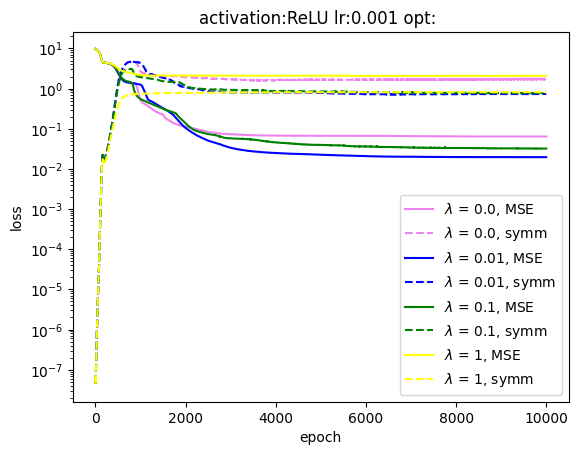

In [140]:
anet.plot_losses()

In [137]:
anet.train_labels

tensor([-1.5986, -2.5029, -0.7063, -1.3790, -4.1499, -2.0813, -6.2417, -4.9128,
        -2.2446, -2.1262, -4.0836, -1.8284, -3.1214, -2.2091,  0.1920, -3.4462,
        -2.5228,  1.0998, -2.8482, -3.4733, -2.3136, -3.7802, -1.4429, -1.5336,
        -1.8487, -2.5086, -0.6351, -3.6971, -1.4326, -2.6159, -4.1545,  0.2826,
        -7.7296, -2.1860, -2.8295,  0.9205, -1.6908, -2.4165, -4.2762, -0.7219,
        -3.0411, -3.7562,  0.1268, -3.6525,  3.0308, -1.5158, -3.5532, -2.5295,
        -4.1612, -0.6034, -1.1405, -1.1754, -6.7769, -1.9569, -3.3874, -7.5819,
        -4.9902, -2.0582, -1.8338, -5.0778, -1.4860, -4.5509, -2.2740, -4.1862,
        -0.5743, -1.8170, -2.0432, -1.4875, -3.5220,  1.3745,  1.0315, -4.2765,
        -3.0292, -0.7037, -1.0875, -1.6170, -4.6652, -1.5175, -0.4716, -1.6910,
        -0.9668, -4.6823, -2.3139, -2.2515, -2.7362,  0.5495, -1.6632,  0.0557,
        -1.8917, -6.9899, -2.4593,  2.3952, -4.6417,  1.9514, -8.3734, -2.8190,
         0.1959, -0.5439, -2.6715, -2.35

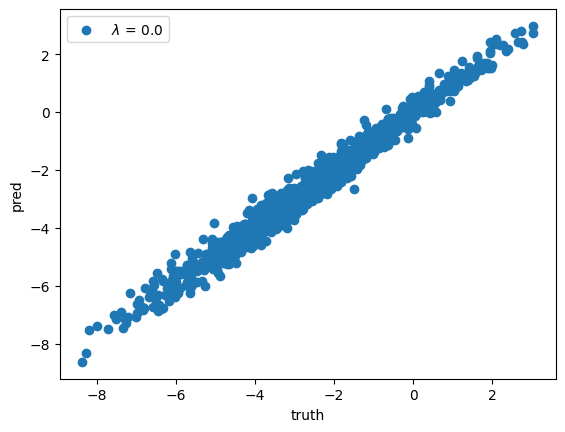

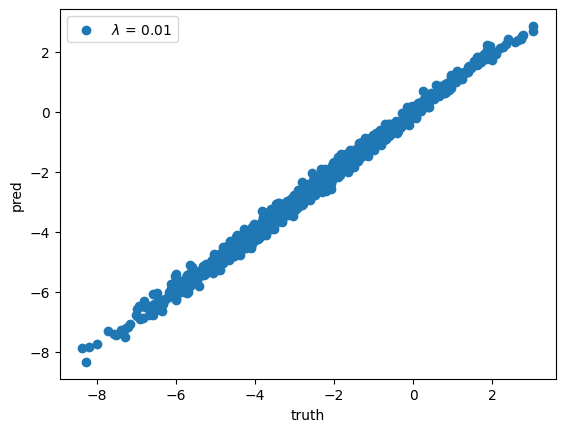

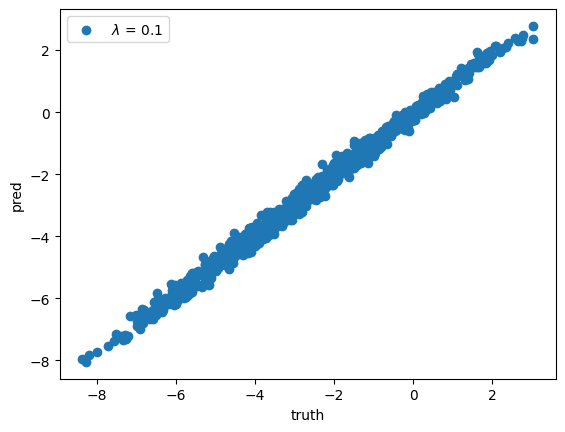

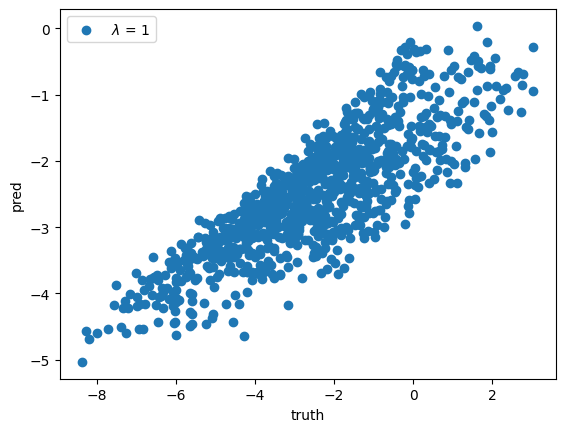

In [141]:
anet.pred_plot()

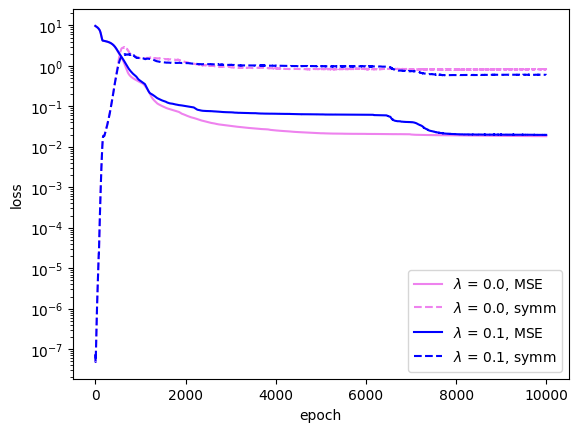

In [110]:
symm_net.plot_losses()

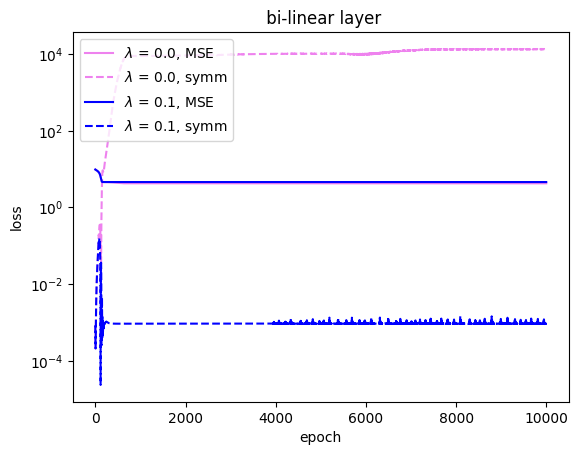

In [91]:
symm_net.plot_losses()

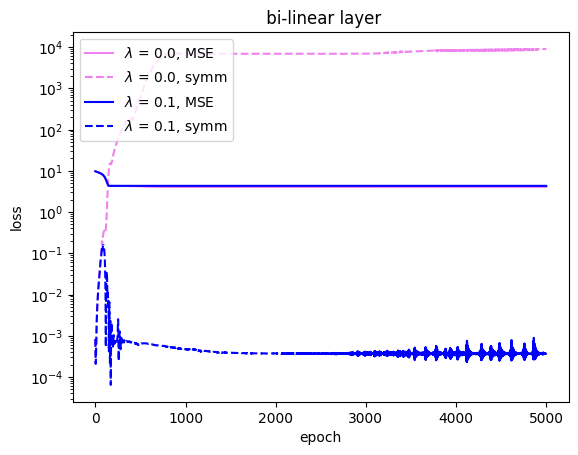

In [72]:
symm_net.plot_losses()